In [1]:
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import pandas_profiling

import re
from datetime import datetime, timedelta 
import time
import ast
from ast import literal_eval

import matplotlib.pyplot as plt
import seaborn as sns 
%matplotlib inline

# Загружаем специальный удобный инструмент для разделения датасета:
from sklearn.model_selection import train_test_split
from sklearn import preprocessing

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

df = pd.read_csv('main_task.csv')
kaggle = pd.read_csv('kaggle_task.csv')
sample_submission = pd.read_csv('sample_submission.csv')

In [2]:
# всегда фиксируйте RANDOM_SEED чтоб ваши эксперементы были воспроизводимы!
RANDOM_SEED = 42

In [3]:
# зафиксируем версию пакетов чтоб эксперементы были воспроизводимы
!pip freeze > requirements.txt

In [4]:
#df_train = pd.read_csv('/kaggle/input/kaggle-sf-dst-through-1/main_task.csv/main_task.csv')
#df_test = pd.read_csv('/kaggle/input/kaggle-sf-dst-through-1/kaggle_task.csv')
#sample_submission = pd.read_csv('/kaggle/input/kaggle-sf-dst-through-1/sample_submission.csv/sample_submission.csv')
# ВАЖНО! дря корректной обработки признаков объединяем трейн и тест в один датасет
#df_train['sample'] = 1 # помечаем где у нас трейн
#df_test['sample'] = 0 # помечаем где у нас тест
#df_test['Rating'] = 0 # в тесте у нас нет значения Rating, мы его должны предсказать, по этому пока просто заполняем нулями

#data = df_test.append(df_train, sort=False).reset_index(drop=True) # объединяем

df['sample'] = 1 # помечаем где у нас трейн
kaggle['sample'] = 0 # помечаем где у нас тест
kaggle['Rating'] = 0 # в тесте у нас нет значения Rating, мы его должны предсказать, по этому пока просто заполняем нулями

data = kaggle.append(df, sort=False).reset_index(drop=True) # объединяем

In [5]:
df

,Restaurant_id,City,Cuisine Style,Ranking,Rating,Price Range,Number of Reviews,Reviews,URL_TA,ID_TA,sample
0,id_5569,Paris,"['European', 'French', 'International']",5570.0,3.5,$$ - $$$,194.0,"[['Good food at your doorstep', 'A good hotel ...",/Restaurant_Review-g187147-d1912643-Reviews-R_...,d1912643,1
1,id_1535,Stockholm,NaN,1537.0,4.0,NaN,10.0,"[['Unique cuisine', 'Delicious Nepalese food']...",/Restaurant_Review-g189852-d7992032-Reviews-Bu...,d7992032,1
2,id_352,London,"['Japanese', 'Sushi', 'Asian', 'Grill', 'Veget...",353.0,4.5,$$$$,688.0,"[['Catch up with friends', 'Not exceptional'],...",/Restaurant_Review-g186338-d8632781-Reviews-RO...,d8632781,1
3,id_3456,Berlin,NaN,3458.0,5.0,NaN,3.0,"[[], []]",/Restaurant_Review-g187323-d1358776-Reviews-Es...,d1358776,1
4,id_615,Munich,"['German', 'Central European', 'Vegetarian Fri...",621.0,4.0,$$ - $$$,84.0,"[['Best place to try a Bavarian food', 'Nice b...",/Restaurant_Review-g187309-d6864963-Reviews-Au...,d6864963,1
5,id_1418,Oporto,NaN,1419.0,3.0,NaN,2.0,"[['There are better 3 star hotel bars', 'Amazi...",/Restaurant_Review-g189180-d12503536-Reviews-D...,d12503536,1
6,id_1720,Milan,"['Italian', 'Pizza']",1722.0,4.0,$,50.0,"[['Excellent simple local eatery.', 'Excellent...",/Restaurant_Review-g187849-d5808504-Reviews-Pi...,d5808504,1
7,id_825,Bratislava,['Italian'],826.0,3.0,NaN,9.0,"[['Wasting of money', 'excellent cuisine'], ['...",/Restaurant_Review-g274924-d3199765-Reviews-Ri...,d3199765,1
8,id_2690,Vienna,NaN,2692.0,4.0,NaN,NaN,"[[], []]",/Restaurant_Review-g190454-d12845029-Reviews-G...,d12845029,1
9,id_4209,Rome,"['Italian', 'Pizza', 'Fast Food']",4210.0,4.0,$,55.0,"[['Clean efficient staff', 'Nice little pizza ...",/Restaurant_Review-g187791-d8020681-Reviews-Qu...,d8020681,1


In [6]:
num_city = {'Paris': 10958187, 'Stockholm': 1608037, 'London': 9176530,
 'Berlin': 3556792, 'Munich': 1521417,
 'Oporto': 1309805, 'Milan': 3136077,
 'Bratislava': 432508, 'Vienna': 1915338,
 'Rome': 4234019, 'Barcelona': 782636,
 'Madrid': 6559041, 'Dublin': 1214666,
 'Brussels': 2065284, 'Zurich': 1383092,
 'Warsaw': 1775933, 'Budapest': 1763913,
 'Copenhagen': 1333888, 'Amsterdam': 1140339,
 'Lyon': 1704738, 'Hamburg': 1791120,
 'Lisbon': 2942097, 'Prague': 1298804,
 'Oslo': 1026758, 'Helsinki': 1292232,
 'Edinburgh': 530741, 'Geneva': 198979,
 'Ljubljana': 288307, 'Athens': 3154152,
 'Luxembourg': 620437, 'Krakow': 760000}
data['Population'] = data['City'].map(num_city)
data['over_mln'] = data['Population'].apply(lambda x: 1 if x > 1000000 else 0)

In [7]:
city_avg = data.groupby(['City'])['Ranking'].median()
city_num = data['City'].value_counts(ascending=False)
data['mean_city'] = data['City'].apply(lambda x: city_avg[x])
data['count_city'] = data['City'].apply(lambda x: city_num[x])
data['ranking_upd_city'] = (data['Ranking'] - data['mean_city']) / data['count_city']

In [8]:
city_min = data.groupby(['City'])['Ranking'].min()
city_max = data.groupby(['City'])['Ranking'].max()
data['min_city'] = data['City'].apply(lambda x: city_min[x])
data['max_city'] = data['City'].apply(lambda x: city_max[x])
data['normalized_city'] = (data['Ranking'] - data['min_city']) / (data['max_city'] - data['min_city'])

In [9]:
city_avg = data.groupby(['City'])['Ranking'].median()
city_std = data.groupby(['City'])['Ranking'].std()
data['mean_city'] = data['City'].apply(lambda x: city_avg[x])
data['std_city'] = data['City'].apply(lambda x: city_std[x])
data['standardized_city'] = (data['Ranking'] - data['mean_city']) / data['std_city']

In [10]:
#Dropping the outlier rows with standard deviation
factor = 3
upper_lim_city = data.groupby(['City'])['Ranking'].median() + data.groupby(['City'])['Ranking'].std () * factor
lower_lim_city = data.groupby(['City'])['Ranking'].median() - data.groupby(['City'])['Ranking'].std () * factor
data['upper_lim_city'] = data['City'].apply(lambda x: upper_lim_city[x])
data['lower_lim_city'] = data['City'].apply(lambda x: lower_lim_city[x])
#data = data[(data['column'] < upper_lim) & (data['column'] > lower_lim)]

In [11]:
#Numerical Binning Example
#data['bin'] = pd.cut(data['value'], bins=[0,30,70,100], labels=["Low", "Mid", "High"])

In [12]:
country_city = {'Paris': 'France', 'Stockholm': 'Sweden', 'London': 'England',
 'Berlin': 'Germany', 'Munich': 'Germany',
 'Oporto': 'Portugal', 'Milan': 'Italy',
 'Bratislava': 'Slovakia', 'Vienna': 'Austria',
 'Rome': 'Italy', 'Barcelona': 'Spain',
 'Madrid': 'Spain', 'Dublin': 'Ireland',
 'Brussels': 'Belgium', 'Zurich': 'Switzerland',
 'Warsaw': 'Poland', 'Budapest': 'Hungary',
 'Copenhagen': 'Denmark', 'Amsterdam': 'Netherlands',
 'Lyon': 'France', 'Hamburg': 'Germany',
 'Lisbon': 'Portugal', 'Prague': 'Czech',
 'Oslo': 'Norway', 'Helsinki': 'Finland',
 'Edinburgh': 'Scotland', 'Geneva': "Switzerland",
 'Ljubljana': 'Slovenia', 'Athens': "Greece",
 'Luxembourg': 'Luxembourg', 'Krakow': 'Poland'}
data['Country'] = data['City'].map(country_city)
data['Country'].unique()

array(['France', 'Finland', 'Scotland', 'England', 'Slovakia', 'Portugal',
       'Hungary', 'Sweden', 'Italy', 'Germany', 'Czech', 'Austria',
       'Ireland', 'Spain', 'Belgium', 'Norway', 'Netherlands', 'Greece',
       'Poland', 'Denmark', 'Luxembourg', 'Switzerland', 'Slovenia'],
      dtype=object)

In [13]:
#Log Transform Example
#data = pd.DataFrame({'value':[2,45, -23, 85, 28, 2, 35, -12]})
data['log+1_ranking'] = (data['Ranking']+1).transform(np.log)
#Negative Values Handling
#Note that the values are different
#data['log'] = (data['value']-data['value'].min()+1) .transform(np.log)

In [14]:
country_avg = data.groupby(['Country'])['Ranking'].median()
country_num = data['Country'].value_counts(ascending=False)
data['mean_country'] = data['Country'].apply(lambda x: country_avg[x])
data['count_country'] = data['Country'].apply(lambda x: country_num[x])
data['ranking_upd_country'] = (data['Ranking'] - data['mean_country']) / data['count_country']

In [15]:
country_min = data.groupby(['Country'])['Ranking'].min()
country_max = data.groupby(['Country'])['Ranking'].max()
data['min_country'] = data['Country'].apply(lambda x: country_min[x])
data['max_country'] = data['Country'].apply(lambda x: country_max[x])
data['normalized_country'] = (data['Ranking'] - data['min_country']) / (data['max_country'] - data['min_country'])

In [16]:
country_avg = data.groupby(['Country'])['Ranking'].median()
country_std = data.groupby(['Country'])['Ranking'].std()
data['mean_country'] = data['Country'].apply(lambda x: country_avg[x])
data['std_country'] = data['Country'].apply(lambda x: country_std[x])
data['standardized_country'] = (data['Ranking'] - data['mean_country']) / data['std_country']

In [17]:
#data = pd.DataFrame({'value':[2,45, -23, 85, 28, 2, 35, -12]})

#data['normalized'] = (data['value'] - data['value'].min()) / (data['value'].max() - data['value'].min())

In [18]:
capitals=['Paris', 'Stockholm', 'London', 'Berlin',
       'Bratislava', 'Vienna', 'Rome', 'Madrid',
       'Dublin', 'Brussels', 'Warsaw', 'Budapest', 'Copenhagen',
       'Amsterdam', 'Lisbon', 'Prague', 'Oslo',
       'Helsinki', 'Edinburgh',  'Ljubljana', 'Athens',
       'Luxembourg']

In [19]:
def capital_check(city):
    if city == city in capitals:
        return 1
    else:
        return 0
data['Capital'] = data.City.apply(capital_check)

In [20]:
capital_avg = data.groupby(['Capital'])['Ranking'].median()
capital_num = data['Capital'].value_counts(ascending=False)
data['mean_capital'] = data['Capital'].apply(lambda x: capital_avg[x])
data['count_capital'] = data['Capital'].apply(lambda x: capital_num[x])
data['ranking_upd_capital'] = (data['Ranking'] - data['mean_capital']) / data['count_capital']

In [21]:
capital_min = data.groupby(['Capital'])['Ranking'].min()
capital_max = data.groupby(['Capital'])['Ranking'].max()
data['min_capital'] = data['Capital'].apply(lambda x: capital_min[x])
data['max_capital'] = data['Capital'].apply(lambda x: capital_max[x])
data['normalized_capital'] = (data['Ranking'] - data['min_capital']) / (data['max_capital'] - data['min_capital'])

In [22]:
over_mln_avg = data.groupby(['over_mln'])['Ranking'].median()
over_mln_num = data['over_mln'].value_counts(ascending=False)
data['mean_over_mln'] = data['over_mln'].apply(lambda x: over_mln_avg[x])
data['count_over_mln'] = data['over_mln'].apply(lambda x: over_mln_num[x])
data['ranking_upd_over_mln'] = (data['Ranking'] - data['mean_over_mln']) / data['count_over_mln']

In [23]:
over_mln_min = data.groupby(['over_mln'])['Ranking'].min()
over_mln_max = data.groupby(['over_mln'])['Ranking'].max()
data['min_over_mln'] = data['over_mln'].apply(lambda x: over_mln_min[x])
data['max_over_mln'] = data['over_mln'].apply(lambda x: over_mln_max[x])
data['normalized_over_mln'] = (data['Ranking'] - data['min_over_mln']) / (data['max_over_mln'] - data['min_over_mln'])

In [24]:
top_restaurant_cities = ['Madrid' ,'Rome', 'Paris', 'London', 'Milan', 'Barcelona', 'Berlin']

def top_cities_check(city):
    if city == city in top_restaurant_cities:
        return 1
    else:
        return 0
data['Top_Restaurant_Cities'] = data.City.apply(top_cities_check)

In [25]:
top_restaurant_cities_avg = data.groupby(['Top_Restaurant_Cities'])['Ranking'].median()
top_restaurant_cities_num = data['Top_Restaurant_Cities'].value_counts(ascending=False)
data['mean_top_restaurant_cities'] = data['Top_Restaurant_Cities'].apply(lambda x: top_restaurant_cities_avg[x])
data['count_top_restaurant_cities'] = data['Top_Restaurant_Cities'].apply(lambda x: top_restaurant_cities_num[x])
data['ranking_upd_top_restaurant_cities'] = (data['Ranking'] - data['mean_top_restaurant_cities']) / data['count_top_restaurant_cities']

In [26]:
top_restaurant_cities_min = data.groupby(['Top_Restaurant_Cities'])['Ranking'].min()
top_restaurant_cities_max = data.groupby(['Top_Restaurant_Cities'])['Ranking'].max()
data['min_top_restaurant_cities'] = data['Top_Restaurant_Cities'].apply(lambda x: top_restaurant_cities_min[x])
data['max_top_restaurant_cities'] = data['Top_Restaurant_Cities'].apply(lambda x: top_restaurant_cities_max[x])
data['normalized_top_restaurant_cities'] = (data['Ranking'] - data['min_top_restaurant_cities']) / (data['max_top_restaurant_cities'] - data['min_top_restaurant_cities'])

In [27]:
east_europe = ['Krakow', 'Warsaw', 'Budapest', 'Bratislava', 'Prague', 'Ljubljana',]

def east_europe_check(city):
    if city == city in east_europe:
        return 1
    else:
        return 0
data['East_Europe'] = data.City.apply(east_europe_check)

In [28]:
east_europe_avg = data.groupby(['East_Europe'])['Ranking'].median()
east_europe_num = data['East_Europe'].value_counts(ascending=False)
data['mean_east_europe'] = data['East_Europe'].apply(lambda x: east_europe_avg[x])
data['count_east_europe'] = data['East_Europe'].apply(lambda x: east_europe_num[x])
data['ranking_upd_east_europe'] = (data['Ranking'] - data['mean_east_europe']) / data['count_east_europe']

In [29]:
east_europe_min = data.groupby(['East_Europe'])['Ranking'].min()
east_europe_max = data.groupby(['East_Europe'])['Ranking'].max()
data['min_east_europe'] = data['East_Europe'].apply(lambda x: east_europe_min[x])
data['max_east_europe'] = data['East_Europe'].apply(lambda x: east_europe_max[x])
data['normalized_east_europe'] = (data['Ranking'] - data['min_east_europe']) / (data['max_east_europe'] - data['min_east_europe'])

In [30]:
Tripadvisor_Tourist_City = ['Paris', 'London', 'Vienna', 'Krakow', 'Prague', 'Lisbon', 'Budapest', 
                            'Berlin', 'Rome', 'Barcelona', 'Edinburgh', 'Amsterdam']

def tripadvisor_tourist_city_check(city):
    if city == city in Tripadvisor_Tourist_City:
        return 1
    else:
        return 0
data['Tripadvisor_Tourist_City'] = data.City.apply(tripadvisor_tourist_city_check)

In [31]:
tripadvisor_tourist_city_avg = data.groupby(['Tripadvisor_Tourist_City'])['Ranking'].median()
tripadvisor_tourist_city_num = data['Tripadvisor_Tourist_City'].value_counts(ascending=False)
data['mean_tripadvisor_tourist_city'] = data['Tripadvisor_Tourist_City'].apply(lambda x: tripadvisor_tourist_city_avg[x])
data['count_tripadvisor_tourist_city'] = data['Tripadvisor_Tourist_City'].apply(lambda x: tripadvisor_tourist_city_num[x])
data['ranking_upd_tripadvisor_tourist_city'] = (data['Ranking'] - data['mean_tripadvisor_tourist_city']) / data['count_tripadvisor_tourist_city']

In [32]:
tripadvisor_tourist_city_min = data.groupby(['Tripadvisor_Tourist_City'])['Ranking'].min()
tripadvisor_tourist_city_max = data.groupby(['Tripadvisor_Tourist_City'])['Ranking'].max()
data['min_tripadvisor_tourist_city'] = data['Tripadvisor_Tourist_City'].apply(lambda x: tripadvisor_tourist_city_min[x])
data['max_tripadvisor_tourist_city'] = data['Tripadvisor_Tourist_City'].apply(lambda x: tripadvisor_tourist_city_max[x])
data['normalized_tripadvisor_tourist_city'] = (data['Ranking'] - data['min_tripadvisor_tourist_city']) / (data['max_tripadvisor_tourist_city'] - data['min_tripadvisor_tourist_city'])

In [33]:
top_rank_city = pd.DataFrame(data.groupby(['City'])['Ranking'].max()).reset_index()
top_rank_city_index = top_rank_city.set_index('City')['Ranking'].to_dict()
data['City_Rank'] = data['City'].map(top_rank_city_index)
top_rank_country = pd.DataFrame(data.groupby(['Country'])['Ranking'].max()).reset_index()
top_rank_country_index = top_rank_country.set_index('Country')['Ranking'].to_dict()
data['Country_Rank'] = data['Country'].map(top_rank_country_index)

In [34]:
#df['Cuisine Style'] = df['Cuisine Style'].astype(str)
data['Cuisine Style'].fillna("['European']", inplace = True)

In [35]:
from ast import literal_eval
data['Cuisine Style'] = data['Cuisine Style'].fillna('["zero"]')

cuisine_set = set()  
for i in data['Cuisine Style']: 
    for j in literal_eval(i):
        cuisine_set.add(j)

def total_sum_cuisine(cuisine):
    if literal_eval(cuisine) == ["zero"]:
        return 0
    return len(literal_eval(cuisine))
data['Cuisines_Number'] = data['Cuisine Style'].apply(total_sum_cuisine)

In [36]:
def only_one_cuisine_check(cuisine):
    if cuisine == 1:
        return 1
    else:
        return 0

def only_two_cuisine_check(cuisine):
    if cuisine == 2:
        return 1
    else:
        return 0   

def only_three_cuisine_check(cuisine):
    if cuisine == 3:
        return 1
    else:
        return 0   

data['only_one_cuisine'] = data['Cuisines_Number'].apply(only_one_cuisine_check)
data['only_two_cuisine'] = data['Cuisines_Number'].apply(only_two_cuisine_check)
data['only_three_cuisine'] = data['Cuisines_Number'].apply(only_three_cuisine_check)

In [37]:
number_of_cuisines_city_avg = data.groupby(['City'])['Cuisines_Number'].median()
number_of_cuisines_city_num = data['City'].value_counts(ascending=False)
data['mean_number_of_cuisines_city'] = data['City'].apply(lambda x: number_of_cuisines_city_avg[x])
data['count_number_of_cuisines_city'] = data['City'].apply(lambda x: number_of_cuisines_city_num[x])
data['ranking_upd_number_of_cuisines_city'] = (data['Cuisines_Number'] - data['mean_number_of_cuisines_city']) / data['count_number_of_cuisines_city']

In [38]:
number_of_cuisines_country_avg = data.groupby(['Country'])['Cuisines_Number'].median()
number_of_cuisines_country_num = data['Country'].value_counts(ascending=False)
data['mean_number_of_cuisines_country'] = data['Country'].apply(lambda x: number_of_cuisines_country_avg[x])
data['count_number_of_cuisines_country'] = data['Country'].apply(lambda x: number_of_cuisines_country_num[x])
data['ranking_upd_number_of_cuisines_country'] = (data['Cuisines_Number'] - data['mean_number_of_cuisines_country']) / data['count_number_of_cuisines_country']

In [39]:
number_of_cuisines_capital_avg = data.groupby(['Capital'])['Cuisines_Number'].median()
number_of_cuisines_capital_num = data['Capital'].value_counts(ascending=False)
data['mean_number_of_cuisines_capital'] = data['Capital'].apply(lambda x: number_of_cuisines_capital_avg[x])
data['count_number_of_cuisines_capital'] = data['Capital'].apply(lambda x: number_of_cuisines_capital_num[x])
data['ranking_upd_number_of_cuisines_capital'] = (data['Cuisines_Number'] - data['mean_number_of_cuisines_capital']) / data['count_number_of_cuisines_capital']

In [40]:
number_of_cuisines_top_restaurant_cities_avg = data.groupby(['Top_Restaurant_Cities'])['Cuisines_Number'].median()
number_of_cuisines_top_restaurant_cities_num = data['Top_Restaurant_Cities'].value_counts(ascending=False)
data['mean_number_of_cuisines_top_restaurant_cities'] = data['Top_Restaurant_Cities'].apply(lambda x: number_of_cuisines_top_restaurant_cities_avg[x])
data['count_number_of_cuisines_top_restaurant_cities'] = data['Top_Restaurant_Cities'].apply(lambda x: number_of_cuisines_top_restaurant_cities_num[x])
data['ranking_upd_number_of_cuisines_capital'] = (data['Cuisines_Number'] - data['mean_number_of_cuisines_top_restaurant_cities']) / data['count_number_of_cuisines_top_restaurant_cities']

In [41]:
number_of_cuisines_east_europe_avg = data.groupby(['East_Europe'])['Cuisines_Number'].median()
number_of_cuisines_east_europe_num = data['East_Europe'].value_counts(ascending=False)
data['mean_number_of_cuisines_east_europe'] = data['East_Europe'].apply(lambda x: number_of_cuisines_east_europe_avg[x])
data['count_number_of_cuisines_east_europe'] = data['East_Europe'].apply(lambda x: number_of_cuisines_east_europe_num[x])
data['ranking_upd_number_of_cuisines_east_europe'] = (data['Cuisines_Number'] - data['mean_number_of_cuisines_east_europe']) / data['count_number_of_cuisines_east_europe']

In [42]:
number_of_cuisines_tripadvisor_tourist_city_avg = data.groupby(['Tripadvisor_Tourist_City'])['Cuisines_Number'].median()
number_of_cuisines_tripadvisor_tourist_city_num = data['Tripadvisor_Tourist_City'].value_counts(ascending=False)
data['mean_number_of_cuisines_tripadvisor_tourist_city'] = data['Tripadvisor_Tourist_City'].apply(lambda x: number_of_cuisines_tripadvisor_tourist_city_avg[x])
data['count_number_of_cuisines_tripadvisor_tourist_city'] = data['Tripadvisor_Tourist_City'].apply(lambda x: number_of_cuisines_tripadvisor_tourist_city_num[x])
data['ranking_upd_number_of_cuisines_tripadvisor_tourist_city'] = (data['Cuisines_Number'] - data['mean_number_of_cuisines_tripadvisor_tourist_city']) / data['count_number_of_cuisines_tripadvisor_tourist_city']

In [43]:
top_rank_kitchen = pd.DataFrame(data.groupby(['City'])['Cuisines_Number'].max()).reset_index()
top_rank_kitchen_index = top_rank_kitchen.set_index('City')['Cuisines_Number'].to_dict()
data['City_Rank_Kitchen'] = data['City'].map(top_rank_kitchen_index)
top_rank_kitchen_country = pd.DataFrame(data.groupby(['Country'])['Cuisines_Number'].max()).reset_index()
top_rank_kitchen_country_index = top_rank_kitchen_country.set_index('Country')['Cuisines_Number'].to_dict()
data['Country_Rank_Kitchen'] = data['Country'].map(top_rank_kitchen_country_index)

In [44]:
#Делаем функцию делящую лист на равные части
def split(arr, size):
    arrs = []
    while len(arr) > size:
        pice = arr[:size]
        arrs.append(pice)
        arr = arr[size:]
    arrs.append(arr)
    return arrs

#Делим на равные части
asde = split(sorted(data['Ranking']), 4000)

 #Делаем функцию, возвращающую 1, если значение естьв промежутке
def parsrating(s):
    if asde[i][0] <= s <= asde[i][-1]:
        return 1
    return 0

 #Применяем функцию
for i in range(10):
    data[i] = data['Ranking'].apply(parsrating)

In [45]:
data['Number of Reviews'] = data['Number of Reviews'].fillna(0)
data['max_reviews'] = data['Number of Reviews'].apply(lambda x: 1 if x>200 else 0)

In [46]:
number_of_reviews_city_avg = data.groupby(['City'])['Number of Reviews'].median()
number_of_reviews_city_num = data['City'].value_counts(ascending=False)
data['mean_number_of_reviews_city'] = data['City'].apply(lambda x: number_of_reviews_city_avg[x])
data['count_number_of_reviews_city'] = data['City'].apply(lambda x: number_of_reviews_city_num[x])
data['ranking_upd_number_of_reviews_city'] = (data['Number of Reviews'] - data['mean_number_of_reviews_city']) / data['count_number_of_reviews_city']

In [47]:
number_of_reviews_country_avg = data.groupby(['Country'])['Number of Reviews'].median()
number_of_reviews_country_num = data['Country'].value_counts(ascending=False)
data['mean_number_of_reviews_country'] = data['Country'].apply(lambda x: number_of_reviews_country_avg[x])
data['count_number_of_reviews_country'] = data['Country'].apply(lambda x: number_of_reviews_country_num[x])
data['ranking_upd_number_of_reviews_country'] = (data['Number of Reviews'] - data['mean_number_of_reviews_country']) / data['count_number_of_reviews_country']

In [48]:
number_of_reviews_capital_avg = data.groupby(['Capital'])['Number of Reviews'].median()
number_of_reviews_capital_num = data['Capital'].value_counts(ascending=False)
data['mean_number_of_reviews_capital'] = data['Capital'].apply(lambda x: number_of_reviews_capital_avg[x])
data['count_number_of_reviews_capital'] = data['Capital'].apply(lambda x: number_of_reviews_capital_num[x])
data['ranking_upd_number_of_reviews_capital'] = (data['Number of Reviews'] - data['mean_number_of_reviews_capital']) / data['count_number_of_reviews_capital']

In [49]:
number_of_reviews_over_mln_avg = data.groupby(['over_mln'])['Number of Reviews'].median()
number_of_reviews_over_mln_num = data['over_mln'].value_counts(ascending=False)
data['mean_number_of_reviews_over_mln'] = data['over_mln'].apply(lambda x: number_of_reviews_over_mln_avg[x])
data['count_number_of_reviews_over_mln'] = data['over_mln'].apply(lambda x: number_of_reviews_over_mln_num[x])
data['ranking_upd_number_of_reviews_over_mln'] = (data['Number of Reviews'] - data['mean_number_of_reviews_over_mln']) / data['count_number_of_reviews_over_mln']

In [50]:
number_of_reviews_top_restaurant_cities_avg = data.groupby(['Top_Restaurant_Cities'])['Number of Reviews'].median()
number_of_reviews_top_restaurant_cities_num = data['Top_Restaurant_Cities'].value_counts(ascending=False)
data['mean_number_of_reviews_top_restaurant_cities'] = data['Top_Restaurant_Cities'].apply(lambda x: number_of_reviews_top_restaurant_cities_avg[x])
data['count_number_of_reviews_top_restaurant_cities'] = data['Top_Restaurant_Cities'].apply(lambda x: number_of_reviews_top_restaurant_cities_num[x])
data['ranking_upd_number_of_reviews_capital'] = (data['Number of Reviews'] - data['mean_number_of_reviews_top_restaurant_cities']) / data['count_number_of_reviews_top_restaurant_cities']

In [51]:
number_of_reviews_east_europe_avg = data.groupby(['East_Europe'])['Number of Reviews'].median()
number_of_reviews_east_europe_num = data['East_Europe'].value_counts(ascending=False)
data['mean_number_of_reviews_east_europe'] = data['East_Europe'].apply(lambda x: number_of_reviews_east_europe_avg[x])
data['count_number_of_reviews_east_europe'] = data['East_Europe'].apply(lambda x: number_of_reviews_east_europe_num[x])
data['ranking_upd_number_of_reviews_east_europe'] = (data['Number of Reviews'] - data['mean_number_of_reviews_east_europe']) / data['count_number_of_reviews_east_europe']

In [52]:
number_of_reviews_tripadvisor_tourist_city_avg = data.groupby(['Tripadvisor_Tourist_City'])['Number of Reviews'].median()
number_of_reviews_tripadvisor_tourist_city_num = data['Tripadvisor_Tourist_City'].value_counts(ascending=False)
data['mean_number_of_reviews_tripadvisor_tourist_city'] = data['Tripadvisor_Tourist_City'].apply(lambda x: number_of_reviews_tripadvisor_tourist_city_avg[x])
data['count_number_of_reviews_tripadvisor_tourist_city'] = data['Tripadvisor_Tourist_City'].apply(lambda x: number_of_reviews_tripadvisor_tourist_city_num[x])
data['ranking_upd_number_of_reviews_tripadvisor_tourist_city'] = (data['Number of Reviews'] - data['mean_number_of_reviews_tripadvisor_tourist_city']) / data['count_number_of_reviews_tripadvisor_tourist_city']

In [53]:
top_rank_reviews = pd.DataFrame(data.groupby(['City'])['Number of Reviews'].max()).reset_index()
top_rank_reviews_index = top_rank_reviews.set_index('City')['Number of Reviews'].to_dict()
data['City_Rank_Reviews'] = data['City'].map(top_rank_reviews_index)
top_rank_reviews_country = pd.DataFrame(data.groupby(['Country'])['Number of Reviews'].max()).reset_index()
top_rank_reviews_country_index = top_rank_reviews_country.set_index('Country')['Number of Reviews'].to_dict()
data['Country_Rank_Reviews'] = data['Country'].map(top_rank_reviews_country_index)

In [54]:
def zero_review_check(review):
    if review == '[[], []]':
        return 0
    return 1

data['Zero_Review'] = data['Reviews'].apply(zero_review_check)

In [55]:
import collections
cuisine_style_dict = collections.Counter()
cuisine_iter = tuple(set(eval(x)) for x in data['Cuisine Style'] if x > '') 
cuisine_set = sorted(set.union(*cuisine_iter))
dummies = pd.DataFrame(np.zeros((len(data), len(cuisine_set))), columns=cuisine_set)
for i, cuisine in enumerate(data['Cuisine Style']): 
    dummies.loc[i, list(eval(cuisine))] = 1
data = pd.concat([data, dummies], axis = 1)

In [57]:
cuisine_iter

({'Bar', 'Pub'},
 {'European',
  'Gluten Free Options',
  'Scandinavian',
  'Vegan Options',
  'Vegetarian Friendly'},
 {'Vegetarian Friendly'},
 {'European',
  'Gluten Free Options',
  'Italian',
  'Mediterranean',
  'Vegetarian Friendly'},
 {'European',
  'Gluten Free Options',
  'Italian',
  'Mediterranean',
  'Seafood',
  'Vegetarian Friendly'},
 {'Cafe', 'Fast Food', 'French'},
 {'European', 'Portuguese'},
 {'European'},
 {'European', 'Scandinavian'},
 {'Italian'},
 {'European'},
 {'Italian'},
 {'Greek'},
 {'European'},
 {'Central European', 'Czech', 'Eastern European', 'European'},
 {'French'},
 {'Pizza', 'Vegan Options', 'Vegetarian Friendly'},
 {'Bar', 'British', 'Gluten Free Options', 'Pub', 'Vegetarian Friendly'},
 {'European'},
 {'European',
  'Gluten Free Options',
  'Italian',
  'Pizza',
  'Vegetarian Friendly'},
 {'European'},
 {'Bar', 'British', 'Pizza', 'Vegan Options', 'Vegetarian Friendly'},
 {'Mediterranean', 'Spanish', 'Vegetarian Friendly'},
 {'Italian', 'Mediterra

In [58]:
cuisine_set

['Afghani',
 'African',
 'Albanian',
 'American',
 'Arabic',
 'Argentinean',
 'Armenian',
 'Asian',
 'Australian',
 'Austrian',
 'Azerbaijani',
 'Balti',
 'Bangladeshi',
 'Bar',
 'Barbecue',
 'Belgian',
 'Brazilian',
 'Brew Pub',
 'British',
 'Burmese',
 'Cafe',
 'Cajun & Creole',
 'Cambodian',
 'Canadian',
 'Caribbean',
 'Caucasian',
 'Central American',
 'Central Asian',
 'Central European',
 'Chilean',
 'Chinese',
 'Colombian',
 'Contemporary',
 'Croatian',
 'Cuban',
 'Czech',
 'Danish',
 'Delicatessen',
 'Diner',
 'Dutch',
 'Eastern European',
 'Ecuadorean',
 'Egyptian',
 'Ethiopian',
 'European',
 'Fast Food',
 'Filipino',
 'French',
 'Fujian',
 'Fusion',
 'Gastropub',
 'Georgian',
 'German',
 'Gluten Free Options',
 'Greek',
 'Grill',
 'Halal',
 'Hawaiian',
 'Healthy',
 'Hungarian',
 'Indian',
 'Indonesian',
 'International',
 'Irish',
 'Israeli',
 'Italian',
 'Jamaican',
 'Japanese',
 'Korean',
 'Kosher',
 'Latin',
 'Latvian',
 'Lebanese',
 'Malaysian',
 'Mediterranean',
 'Mexic

In [59]:
def sum_cs(x):
    agenda = list(eval(x))
    for cuisine in agenda: cuisine_style_dict[cuisine] +=1
    return len(agenda)
data['Cuisine_Number']= data['Cuisine Style'].apply(lambda x: sum_cs(x))

In [60]:
popular_cuisine = data['Cuisine Style'].str.split(pat = ",", expand=True).stack().value_counts().index[0:50]
data['Excellent_Cuisine'] = data['Cuisine Style'].apply(lambda x: 1 if any(word in x for word in popular_cuisine) and x != 'nan' else 0)

In [61]:
data['Price Range'].unique()

array(['$$ - $$$', '$$$$', '$', nan], dtype=object)

In [62]:
data['Price Range'] = data['Price Range'].str.replace(r'(\${4})','3')
data['Price Range'] = data['Price Range'].str.replace(r'(\${2} - \${3})','2')
data['Price Range'] = data['Price Range'].str.replace(r'((?<!\$)\$(?!\$))','1')
data['Price Range'] = data['Price Range'].fillna('2')

#price_dict = {'$': 1, '$$-$$$': 2, '$$$$': 3}
#df['Price'] = df['Price Range'].map(price_dict)

In [63]:
price_range_avg = data.groupby(['Price Range'])['Ranking'].median()
price_range_num = data['Price Range'].value_counts(ascending=False)
data['mean_price_range'] = data['Price Range'].apply(lambda x: price_range_avg[x])
data['count_price_range'] = data['Price Range'].apply(lambda x: price_range_num[x])
data['ranking_upd_price_range'] = (data['Ranking'] - data['mean_price_range']) / data['count_price_range']

In [64]:
number_of_reviews_Price_Range_avg = data.groupby(['Price Range'])['Number of Reviews'].median()
number_of_reviews_Price_Range_num = data['Price Range'].value_counts(ascending=False)
data['mean_number_of_reviews_Price_Range'] = data['Price Range'].apply(lambda x: number_of_reviews_Price_Range_avg[x])
data['count_number_of_reviews_Price_Range'] = data['Price Range'].apply(lambda x: number_of_reviews_Price_Range_num[x])
data['ranking_upd_number_of_reviews_Price_Range'] = (data['Number of Reviews'] - data['mean_number_of_reviews_Price_Range']) / data['count_number_of_reviews_Price_Range']

In [65]:
number_of_cuisines_Price_Range_avg = data.groupby(['Price Range'])['Cuisines_Number'].median()
number_of_cuisines_Price_Range_num = data['Price Range'].value_counts(ascending=False)
data['mean_number_of_cuisines_Price_Range'] = data['Price Range'].apply(lambda x: number_of_cuisines_Price_Range_avg[x])
data['count_number_of_cuisines_Price_Range'] = data['Price Range'].apply(lambda x: number_of_cuisines_Price_Range_num[x])
data['ranking_upd_number_of_cuisines_Price_Range'] = (data['Cuisines_Number'] - data['mean_number_of_cuisines_Price_Range']) / data['count_number_of_cuisines_Price_Range']

In [66]:
data = pd.get_dummies(data, columns=['Country'], dummy_na=True)
data = pd.get_dummies(data, columns=['Price Range'], dummy_na=True)
data = pd.get_dummies(data, columns=['City'], dummy_na=True)

In [67]:
worst = ['small', 'littl', 'simpl', 'typic', 'late', 'busi', 'aw', 'slow', 'mediocre', 'terrible', 'disappoint', 'horrible', 
         'overpriced', 'strange', 'refused', 'unappealing', 'worst', 'boring', 'racism', 'bad', 'expensive','careful', 
         'appalling', ':(', 'amateur', 'dirty', 'rude', 'wretched', 'mean', 'amiss', 'poor', 'worse', 'rip', 'ignored']
best = ['wonderful', 'delight', 'enjoy', 'awesome', 'super', 'charm', 'excellent', 'lovely', ':)', 'friendly', 'yum', 
        'beautiful', 'fresh', 'authentic', 'fantastic', 'talent', 'grand', 'relax', 'best', 'modern', 'cosy', 'right', 
        'unique', 'tasty', 'delicious', 'healthy', 'perfect', 'nice', 'great', 'brilliant', 'amazing', 
        'quick', 'decent', 'pleasant', 'fabulous', 'superb', 'top', 'interesting', 'good', 'fine', 'outstanding', 
        'cute', 'fast', 'pretty', 'cool', 'well', 'better', 'delight', 'sirpris', 'wow', 'tradit', 'cheap',
        'favourit', 'incred', 'conveni', 'relax', 'recommend', 'except', 'fab', 'romant', 'gorgeous', 'comfort', 'heavenly']

In [68]:
data['Reviews'].fillna('[]', inplace=True)
#data['Reviews'].fillna(0, inplace=True)

In [69]:
data['Plus_feedback'] = data['Reviews'].apply(lambda x: 1 if any(word in x.lower() for word in best) else 0)
data['Minus_feedback'] = data['Reviews'].apply(lambda x: 1 if any(word in x.lower() for word in worst) else 0)

In [70]:
data['Ranking'].fillna(data['Ranking'].median(), inplace=True)

In [71]:
data = data.drop(['Cuisine Style', 'URL_TA', 'ID_TA'], axis = 1)

In [72]:
data['First Review'] = data['Reviews'].str.extract(r'(\d{2}\/\d{2}\/\d{4}(?=\'\]))')
data['Last Review'] = data['Reviews'].str.extract(r'(\d{2}\/\d{2}\/\d{4}(?!\'\]))')
data['First Review'] = pd.to_datetime(data['First Review'], format = "%m/%d/%Y")
data['Last Review'] = pd.to_datetime(data['Last Review'], format = "%m/%d/%Y")
data['First Review'] = data['First Review'].fillna(999999)
data['Last Review'] = data['Last Review'].fillna(999999)

In [73]:
data['Last Review'] = data['Last Review'].apply(lambda x: time.mktime(x.timetuple())/24/60/60 if x!=999999 else x).astype(float)
data['First Review'] = data['First Review'].apply(lambda x: time.mktime(x.timetuple())/24/60/60 if x!=999999 else x).astype(float)

In [74]:
mean_first_rev = data['First Review'].median()
data['First Review'] = data['First Review'].apply(lambda x: mean_first_rev if x==999999 else x)
mean_last_rev = data['Last Review'].median()
data['Last Review'] = data['Last Review'].apply(lambda x: mean_last_rev if x==999999 else x)

In [75]:
data['First to Last Review'] = data['Last Review'] - data['First Review']
data['First to Last Review'] = data['First to Last Review'].apply(lambda x: -x if x<0 else x).astype(int)
data['Last Review to Today'] = (time.mktime(datetime.today().timetuple())/24/60/60 - data['Last Review']).astype(int)

In [76]:
data = data.drop(['Reviews', 'Name'], axis = 1)

In [77]:
#data

In [78]:
#pandas_profiling.ProfileReport(data)

In [79]:
#Разбиваем датафрейм на части, необходимые для обучения и тестирования модели

# Х - данные с информацией о ресторанах, у - целевая переменная (рейтинги ресторанов)
#X = data.drop(['Restaurant_id', 'Rating'], axis = 1)
#y = data['Rating']

In [80]:
# Загружаем специальный инструмент для разбивки:
#from sklearn.model_selection import train_test_split
# Наборы данных с меткой "train" будут использоваться для обучения модели, "test" - для тестирования.
# Для тестирования мы будем использовать 25% от исходного датасета.
#X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.25)

In [81]:
#Создаём, обучаем и тестируем модель
# Импортируем необходимые библиотеки:
#from sklearn.ensemble import RandomForestRegressor # инструмент для создания и обучения модели
#from sklearn import metrics # инструменты для оценки точности модели
# Создаём модель
#regr = RandomForestRegressor(n_estimators=100)

In [82]:
# Обучаем модель на тестовом наборе данных
#regr.fit(X_train, y_train)

In [83]:
# Используем обученную модель для предсказания рейтинга ресторанов в тестовой выборке.
# Предсказанные значения записываем в переменную y_pred
#y_pred = regr.predict(X_test)
# Сравниваем предсказанные значения (y_pred) с реальными (y_test), и смотрим насколько они в среднем отличаются
# Метрика называется Mean Absolute Error (MAE) и показывает среднее отклонение предсказанных значений от фактических.
#print('MAE:', metrics.mean_absolute_error(y_test, y_pred))

In [84]:
#plt.rcParams['figure.figsize'] = (10,5)
#feat_importances = pd.Series(regr.feature_importances_, index=X.columns)
#feat_importances.nlargest(10).plot(kind='barh')

In [85]:
# убираем не нужные для модели признаки
data.drop(['Restaurant_id'], axis = 1, inplace=True)

In [86]:
# теперь выделим тестовую часть
train_data = data.query('sample == 1').drop(['sample'], axis=1)

y = train_data.Rating.values            # наш таргет
X = train_data.drop(['Rating'], axis=1)

# Воспользуемся специальной функцие train_test_split для разбивки тестовых данных
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=RANDOM_SEED)

In [87]:
# проверяем
train_data.shape, X.shape, X_train.shape, X_test.shape

((40000, 319), (40000, 318), (32000, 318), (8000, 318))

In [88]:
# Импортируем необходимые библиотеки:
from sklearn.ensemble import RandomForestRegressor # инструмент для создания и обучения модели
from sklearn import metrics # инструменты для оценки точности модели

In [89]:
# Создаём модель (НАСТРОЙКИ НЕ ТРОГАЕМ)
model = RandomForestRegressor(n_estimators=100, verbose=1, n_jobs=-1, random_state=RANDOM_SEED)

In [90]:
# Обучаем модель на тестовом наборе данных
model.fit(X_train, y_train)

# Используем обученную модель для предсказания рейтинга ресторанов в тестовой выборке.
# Предсказанные значения записываем в переменную y_pred
y_pred = model.predict(X_test)

[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  34 tasks      | elapsed:   27.4s
[Parallel(n_jobs=-1)]: Done 100 out of 100 | elapsed:  1.2min finished
[Parallel(n_jobs=8)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done  34 tasks      | elapsed:    0.0s
[Parallel(n_jobs=8)]: Done 100 out of 100 | elapsed:    0.0s finished


In [91]:
# Сравниваем предсказанные значения (y_pred) с реальными (y_test), и смотрим насколько они в среднем отличаются
# Метрика называется Mean Absolute Error (MAE) и показывает среднее отклонение предсказанных значений от фактических.
print('MAE:', metrics.mean_absolute_error(y_test, y_pred))

MAE: 0.19797812499999998


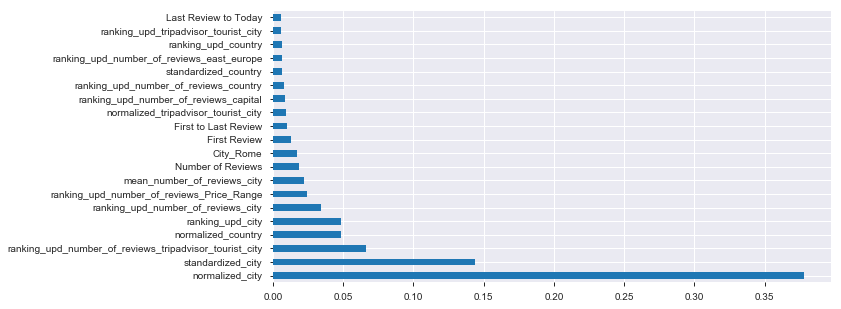

In [92]:
# в RandomForestRegressor есть возможность вывести самые важные признаки для модели
plt.rcParams['figure.figsize'] = (10,5)
feat_importances = pd.Series(model.feature_importances_, index=X.columns)
feat_importances.nlargest(20).plot(kind='barh')

In [93]:
test_data = data.query('sample == 0').drop(['sample'], axis=1)
test_data = test_data.drop(['Rating'], axis=1)

In [94]:
def round_number(number):
    if number < 1.25: number = 1.0
    elif number < 1.75: number = 1.5
    elif number < 2.25: number = 2
    elif number < 2.75: number = 2.5
    elif number < 3.25: number = 3.0
    elif number < 3.75: number = 3.5
    elif number < 4.25: number = 4.0
    elif number < 4.75: number = 4.5
    else: number = 5.0
    return number
round_numbers = np.vectorize(round_number)

In [95]:
predict_submission = model.predict(test_data)

[Parallel(n_jobs=8)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done  34 tasks      | elapsed:    0.0s
[Parallel(n_jobs=8)]: Done 100 out of 100 | elapsed:    0.0s finished


In [96]:
predict_submission = round_numbers(predict_submission)
predict_submission

array([3. , 4.5, 4.5, ..., 3. , 4.5, 4.5])

In [97]:
sample_submission['Rating'] = predict_submission
sample_submission.to_csv('submission2.csv', index=False)
sample_submission.head()

,Restaurant_id,Rating
0,id_0,3.0
1,id_1,4.5
2,id_2,4.5
3,id_3,4.5
4,id_4,4.5
